In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import warnings
warnings.filterwarnings("ignore")

## Load data

In [6]:
df = pd.read_csv('data/president_general_polls_2016.csv')
polls = df[['pollster', 'state', 'startdate', 'enddate', 'samplesize', 'adjpoll_clinton', 'adjpoll_trump']]

## data cleaning

In [7]:
nb_voters = [3606103, 519501, 4738332, 2148441, 25278803, 3978892, 2572337, 693659, 516771, 14601373, 6958725, 
            1029072, 1161211, 8983758, 4860929, 2297129, 2065761, 3276707, 3391431, 1058306, 4202282, 4978165, 
            7431589, 3972330, 2177349, 4519978, 803833, 1353558, 1970426, 1041147, 6093144, 1459901, 13693128, 
            7317507, 582534, 8753269, 2792423, 3006638, 9737690, 786111, 3702997, 632098, 4900137, 17514961, 
            1993581, 496439, 6061032, 5123524, 1430308, 4295057, 431011]

nb_electors = [9, 3, 11, 6, 55, 9, 7, 3, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10, 3, 5, 6, 
               4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]

states = set(df.state.values)
to_remove = ['U.S.', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2']
for s in to_remove: states.remove(s)
polls = polls[polls.state.isin(states)]

has_51 = []
for pst in set(polls.pollster.values):
    if len(set(polls[polls.pollster == pst].state)) >= 51:
        has_51.append(pst)

polls = polls[polls.pollster.isin(has_51)]
polls.dropna(inplace=True)
polls.startdate = pd.to_datetime(polls.startdate)
polls.enddate = pd.to_datetime(polls.enddate)
polls.samplesize = polls.samplesize.astype(np.int32)
polls['trump'] = (polls.samplesize*polls.adjpoll_trump/100).astype(np.int32)
polls['clinton'] = (polls.samplesize*polls.adjpoll_clinton/100).astype(np.int32)
polls['independent'] = (polls.samplesize - (polls.clinton + polls.trump))
polls.drop('adjpoll_trump', axis=1, inplace=True)
polls.drop('adjpoll_clinton', axis=1, inplace=True)
polls.drop('samplesize', axis=1, inplace=True)

grouped = polls.groupby(['pollster', 'state']).sum()
votes = grouped.values.reshape(-1, len(states), 3)

# Model

In [8]:
code = '''
data {
    int nb_polls;
    int nb_states;
    int nb_candidates;
    int votes[nb_polls, nb_states, nb_candidates];
    int nb_voters[nb_states];
    vector[nb_candidates] priors;
}
parameters {
    simplex[nb_candidates] theta[nb_states]; //1 - trump, 2 - clinton, 3 - independent
}
model {
    for(s in 1:nb_states)
        theta[s] ~ dirichlet(priors); 
    for(p in 1:nb_polls)
        for(s in 1:nb_states)
            votes[p, s] ~ multinomial(theta[s]);
}
generated quantities{
    int votes_pred[nb_states, nb_candidates];
    for(s in 1:nb_states)
        votes_pred[s] <- multinomial_rng(theta[s], nb_voters[s]);
}
'''
model = pystan.StanModel(model_code=code)

In [9]:
data = {
    'nb_polls': votes.shape[0],
    'nb_states': votes.shape[1],
    'nb_candidates': votes.shape[2],
    'votes': votes,
    'priors': np.array([1.0, 1.0, 1.0], dtype=np.float32),
    'nb_voters': nb_voters,
}

fit = model.sampling(data=data, iter=1000, chains=4)

In [10]:
print(fit)

Inference for Stan model: anon_model_a0771ccfde63e634a1aa4d683efa60d3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]         0.58  5.2e-5 2.3e-3   0.57   0.57   0.58   0.58   0.58   2000    1.0
theta[1,0]         0.46  8.0e-5 3.6e-3   0.45   0.45   0.46   0.46   0.46   2000    1.0
theta[2,0]         0.43  3.4e-5 1.5e-3   0.43   0.43   0.43   0.44   0.44   2000    1.0
theta[3,0]         0.52  6.3e-5 2.8e-3   0.52   0.52   0.52   0.53   0.53   2000    1.0
theta[4,0]         0.33  2.3e-5 1.0e-3   0.33   0.33   0.33   0.33   0.33   2000    1.0
theta[5,0]         0.39  3.3e-5 1.5e-3   0.39   0.39   0.39   0.39   0.39   2000    1.0
theta[6,0]         0.38  5.0e-5 2.2e-3   0.37   0.37   0.38   0.38   0.38   2000    1.0
theta[7,0]         0.37  7.4e-5 3.3e-3   0.36   0.37   0.37   0.37   0.38   2000    1.0
theta[8,0]          0

In [11]:
trace = fit.extract()

<IPython.core.display.Javascript object>


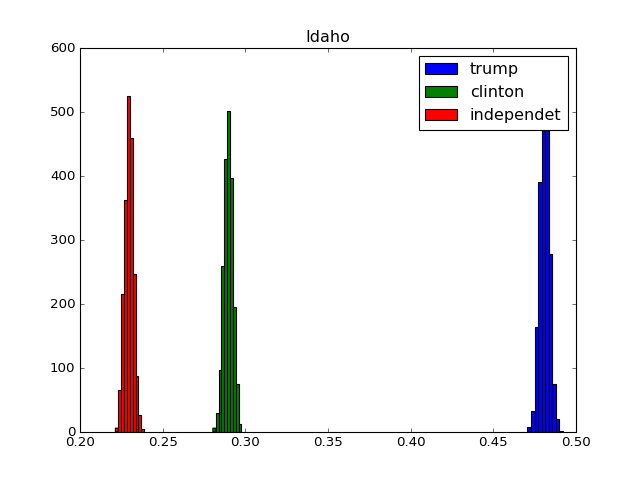

In [24]:
plt.figure()
s = 12
plt.hist(trace['theta'][:, s, 0], label='trump')
plt.hist(trace['theta'][:, s, 1], label='clinton')
plt.hist(trace['theta'][:, s, 2], label='independet')
plt.title(sorted(list(states))[s])
plt.legend()

In [18]:
votes_pred = trace['votes_pred']

In [19]:
votes_pred.shape

(2000, 51, 3)

In [20]:
winner = []
for election_sample in votes_pred:
    cnts = np.zeros(3)
    for s, tci in enumerate(election_sample):
        cnts[tci.argmax()] += nb_electors[s]
    if cnts.max() >= 270:
        winner.append(cnts.argmax())
    else:
        winner.append(-1)

<IPython.core.display.Javascript object>


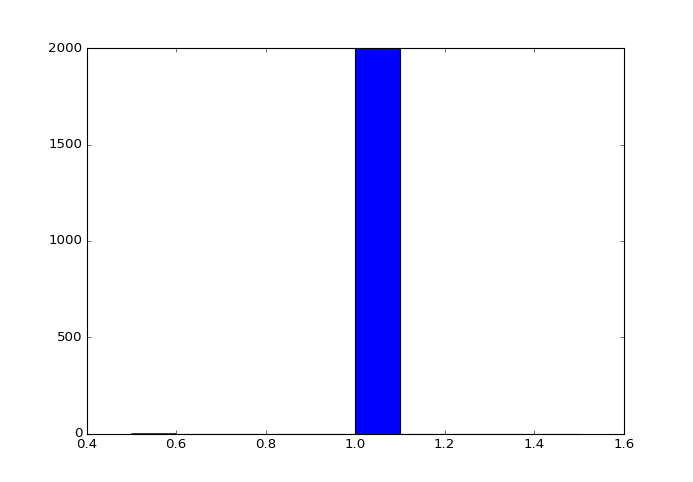

In [31]:
plt.figure()
plt.hist(winner);